# Possion equation II

## 计算收敛阶

+ 和真解对比
+ 和参考解对比
+ 相邻三层之间对比 (Cauchy 序列): [py/possion_convergence.py](py/possion_convergence.py)

### 生成网格序列

```python
base = RectangleMesh(N, N, 1, 1)
meshes = MeshHierarchy(test_mesh, refinement_levels=4)
```

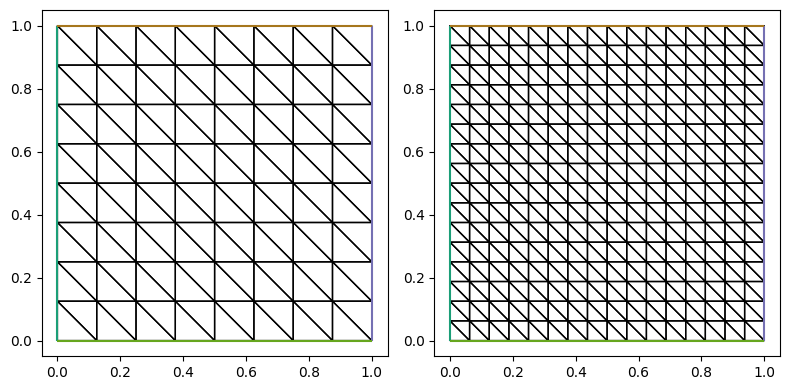

In [ ]:
from firedrake import *
import matplotlib.pyplot as plt

N = 8
base = RectangleMesh(N, N, 1, 1)
meshes = MeshHierarchy(base, refinement_levels=3)

n = len(meshes)
m = min(2, n)
fig, ax = plt.subplots(1, m, figsize=[4*m, 4])
for i in range(m):
    triplot(meshes[i], axes=ax[i])
fig.tight_layout()

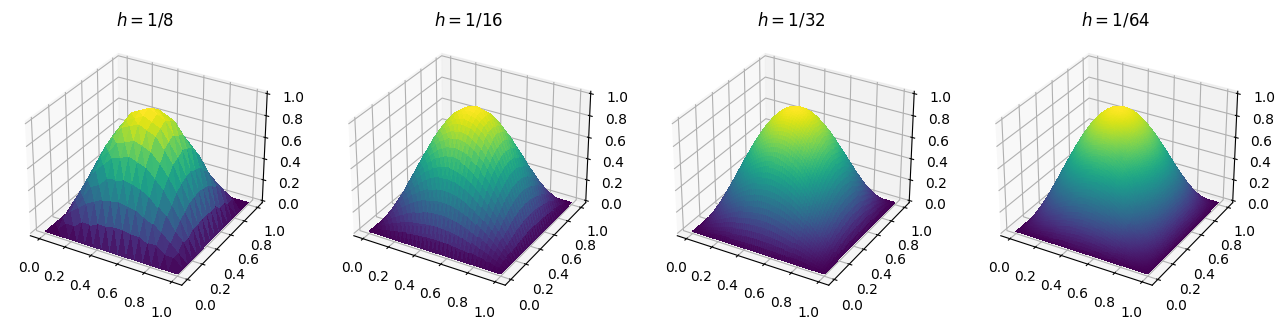

In [ ]:
us = []
for mesh in meshes:
    x, y = SpatialCoordinate(mesh)
    f = sin(pi*x)*sin(pi*y)
    V = FunctionSpace(mesh, 'CG', degree=1)
    u = Function(V).interpolate(f)
    us.append(u)

m = min(4, n)
fig, ax = plt.subplots(1, 4, figsize=[4*4, 4], subplot_kw=dict(projection='3d'))
ax = ax.flat
for i in range(n):
    trisurf(us[i], axes=ax[i])
    ax[i].set_title(f'$h=1/{N*2**i}$')

### 投影到细网格上的空间中

目前 Firedrake 只能投影函数到相邻层的网格上 (由 MeshHierarchy 生成的网格), 和最密网格比较时可以多次投影, 直至最密网格, 然后比较结果.

下面我们仅比较相邻层的误差

In [ ]:
errors = []
hs = []
for i, u in enumerate(us[:-1]):
    u_ref = us[i+1]
    u_inter = project(u, u_ref.function_space())
    error = errornorm(u_ref, u_inter)
    errors.append(error)
    hs.append(1/(N*2**i))

hs, errors

([0.125, 0.0625, 0.03125],
 [0.012284003199971312, 0.003100763810085326, 0.00077706141610528])

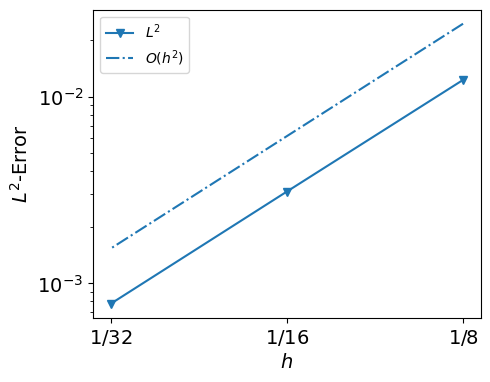

In [ ]:
from py.intro_utils import plot_errors
plot_errors(hs, errors, expect_order=2)

### 插值到细网格上的空间中

+ VertexOnlyMesh
+ PointCloud: https://github.com/lrtfm/fdutils

#### Example of `PointCloud`


Interpolate function `f1` on mesh `m1` to function `f2` on mesh `m2` 

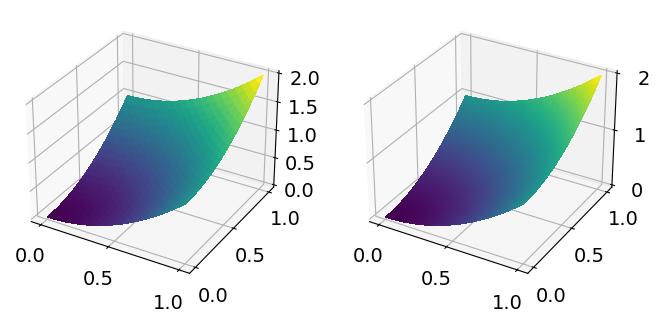

In [ ]:
import firedrake as fd
from fdutils import PointCloud
from fdutils.tools import get_nodes_coords
import matplotlib.pyplot as plt

m1 = fd.RectangleMesh(10, 10, 1, 1)
V1 = fd.FunctionSpace(m1, 'CG', 2)
x, y = fd.SpatialCoordinate(m1)
f1 = fd.Function(V1).interpolate(x**2 + y**2)

m2 = fd.RectangleMesh(20, 20, 1, 1)
V2 = fd.FunctionSpace(m2, 'CG', 3)
f2 = fd.Function(V2)

points = get_nodes_coords(f2)
pc = PointCloud(m1, points, tolerance=1e-12)
f2.dat.data_with_halos[:] = pc.evaluate(f1)

fig, ax = plt.subplots(1, 2, figsize=[8, 4], subplot_kw=dict(projection='3d'))
ts1 = fd.trisurf(f1, axes=ax[0])
ts2 = fd.trisurf(f2, axes=ax[1])

#### 计算误差

In [ ]:
from fdutils.tools import errornorm as my_errornorm

my_errors_0 = []
for i, u in enumerate(us[:-1]):
    # 和相邻层结果比较
    my_errors_0.append(my_errornorm(u, us[i+1], tolerance=1e-12))

my_errors_0

[0.012284003212205774, 0.003100763847789645, 0.0007770614201378605]

In [ ]:
from fdutils.tools import errornorm as my_errornorm

my_errors = []
for i, u in enumerate(us[:-1]):
    # 和最密层结果比较
    my_errors.append(my_errornorm(u, us[-1], tolerance=1e-12))

my_errors

[0.015349062780286471, 0.003718192030819568, 0.0007770614201378605]

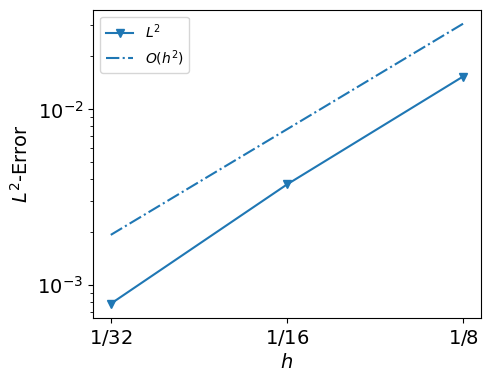

In [ ]:
from py.intro_utils import plot_errors
plot_errors(hs, my_errors, expect_order=2)

## 网格尺寸和质量

### 网格尺寸

网格尺寸 `CellDiameter` 和 `CellSize` 一样, 均为最长边.

也可以直接用 `mesh.cell_sizes` , 这个函数是 `CellSize` 在连续空间 P1 的投影.

内切圆半径 `Circumradius`

:::{warning}
只能作用于线性网格
:::

In [ ]:
from firedrake import *

mesh = RectangleMesh(1, 1, 1, 1)
V = FunctionSpace(mesh, 'DG', 0)

d = CellDiameter(mesh)
d_int = Function(V).interpolate(d)

r = Circumradius(mesh)   # 内切圆半径
r_int = Function(V).interpolate(r)

size = mesh.cell_sizes

In [ ]:
d_int.dat.data, size.dat.data, r_int.dat.data, 

(array([1.41421356, 1.41421356]),
 array([1.41421356, 1.41421356, 1.41421356, 1.41421356]),
 array([0.70710678, 0.70710678]))

In [ ]:
CellDiameter?

Init signature: CellDiameter(domain)
Docstring:     
UFL geometry representation: The diameter of the cell, i.e.,
maximal distance of two points in the cell.
File:           ~/firedrake/real-int32-mkl-debug/src/ufl/ufl/geometry.py
Type:           type
Subclasses:     

In [ ]:
Circumradius?

Init signature: Circumradius(domain)
Docstring:      UFL geometry representation: The circumradius of the cell.
File:           ~/firedrake/real-int32-mkl-debug/src/ufl/ufl/geometry.py
Type:           type
Subclasses:     

### 网格质量

仅作用于线性网格

In [ ]:
from firedrake import *

def get_quality_3d(mesh):
    kernel = r'''
    void get_quality(double coords[4][3], double v[1], double q[1]){
        double a, b, c, p;
        double ls[6];
        double s, r, R, _tmp;
        double v1[3], v2[3], v3[3];
        int idx[6][2] = {{0, 1}, {2, 3}, {0, 2}, {1, 3}, {0, 3}, {1, 2}};
        int idx2[4][3] = {{0, 1, 2}, {0, 2, 3}, {1, 2, 3}, {0, 1, 3}};
        for (int i=0; i < 6; i++){
            _tmp = 0;
            for (int j=0; j < 3; j++){
                _tmp += pow(coords[idx[i][0]][j] - coords[idx[i][1]][j], 2.0);
            }
            ls[i] = sqrt(_tmp);
        }
        a = ls[0]*ls[1];
        b = ls[2]*ls[3];
        c = ls[4]*ls[5];
        p = (a + b + c)/2;

        s = 0;
        for (int i=0; i < 4; i++){
            for (int j = 0; j < 3; j++){
                v1[j] = coords[idx2[i][2]][j] - coords[idx2[i][0]][j];
                v2[j] = coords[idx2[i][2]][j] - coords[idx2[i][1]][j];
            }
            v3[0] =   v2[1]*v1[2] - v2[2]*v1[1];
            v3[1] = - v2[0]*v1[2] + v2[2]*v1[0];
            v3[2] =   v2[0]*v1[1] - v2[1]*v1[0];
            s += sqrt(pow(v3[0], 2.0) + pow(v3[1], 2.0) + pow(v3[2], 2.0))/2;
        }

        R = sqrt(p*(p-a)*(p-b)*(p-c))/v[0]/6.0;
        r = 3*v[0]/s;
        q[0] = r/R;
    }
    '''

    coords =  mesh.coordinates
    V = FunctionSpace(mesh, 'DG', 0)
    volume = Function(V).interpolate(CellVolume(mesh))
    quality = Function(V)

    cell_node_map = quality.cell_node_map()
    op2.par_loop(op2.Kernel(kernel, 'get_quality'), cell_node_map.iterset,
                 coords.dat(op2.READ, coords.cell_node_map()),
                 volume.dat(op2.READ, cell_node_map),
                 quality.dat(op2.WRITE, cell_node_map))

    return quality

def get_quality_2d(mesh):
    V = FunctionSpace(mesh, 'DG', 0)
    quality = Function(V)
    kernel = '''
    // B[2] - B[0], B[3] - B[1]
    // B[4] - B[0], B[5] - B[1]
    double S, a, b, c, R, r;
    S = fabs((B[5] - B[1])*(B[2] - B[0])  - (B[3] - B[1])*(B[4] - B[0]));
    a = sqrt(pow(B[2] - B[0], 2.) + pow(B[3] - B[1], 2.));
    b = sqrt(pow(B[4] - B[2], 2.) + pow(B[5] - B[3], 2.));
    c = sqrt(pow(B[0] - B[4], 2.) + pow(B[1] - B[5], 2.));
    R = a*b*c/(2*S);
    r = S/(a+b+c);
    A[0] = r/R;
    '''

    par_loop(kernel, \
             dx, \
             {'A': (quality, WRITE), 'B' :(mesh.coordinates, READ)})

    return quality

def get_quality_2d_surface(mesh):
    kernel = r'''
    void get_quality(double coords[3][3], double v[1], double q[1]){
        double p, _tmp, R, r, ls[3];
        double S = v[0];
        int idx[3][2] = {{0, 1}, {1, 2}, {0, 2}};
        for (int i=0; i < 3; i++){
            _tmp = 0;
            for (int j=0; j < 3; j++){
                _tmp += pow(coords[idx[i][0]][j] - coords[idx[i][1]][j], 2.0);
            }
            ls[i] = sqrt(_tmp);
        }
        p = (ls[0] + ls[1] + ls[2])/2;
        
        // S = sqrt(p*(p-ls[0])*(p-ls[1])*(p-ls[2]));
        R = ls[0]*ls[1]*ls[2]/(4*S);
        r = S/p;
        q[0] = r/R;
    }
    '''

    coords =  mesh.coordinates
    V = FunctionSpace(mesh, 'DG', 0)
    volume = Function(V).interpolate(CellVolume(mesh))
    quality = Function(V)

    cell_node_map = quality.cell_node_map()
    op2.par_loop(op2.Kernel(kernel, 'get_quality'), cell_node_map.iterset,
                 coords.dat(op2.READ, coords.cell_node_map()),
                 volume.dat(op2.READ, cell_node_map),
                 quality.dat(op2.WRITE, cell_node_map))
    return quality

__2d 和 3d__

In [ ]:
mesh2d = RectangleMesh(1, 1, 1, 1)
mesh3d = UnitCubeMesh(1, 1, 1)

q2 = get_quality_2d(mesh2d)
q3 = get_quality_3d(mesh3d)

In [ ]:
q2.dat.data, q3.dat.data

(array([0.41421356, 0.41421356]),
 array([0.23914631, 0.23914631, 0.23914631, 0.23914631, 0.23914631,
        0.23914631]))

__2d 正三角形__

In [ ]:
from firedrake.petsc import PETSc
from pyop2.datatypes import IntType

cells = np.array([[0, 1, 2]], dtype=IntType)
coords = np.array([[0.0, 0.0],
                   [1.0, 0.0],
                   [1/2, np.sqrt(3)/2]])

plex = PETSc.DMPlex()
plex.createFromCellList(2, cells, coords)
mesh = Mesh(plex)
q_mesh = get_quality_2d(mesh)
q_mesh.dat.data

array([0.5])

__曲面网格__

In [ ]:
mesh_surf = IcosahedralSphereMesh(1)
q_surf = get_quality_2d_surface(mesh_surf)
q_surf.dat.data

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [ ]:
from firedrake.petsc import PETSc
from pyop2.datatypes import IntType

cells = np.array([[0, 1, 2]], dtype=IntType)
coords = np.array([[0.0, 0.0, 0.0],
                   [1.0, 0.0, 0.0],
                   [1/2, np.sqrt(3)/2, 0.0]])

plex = PETSc.DMPlex()
plex.createFromCellList(2, cells, coords)
mesh = Mesh(plex, dim=3)
q_mesh = get_quality_2d_surface(mesh)
q_mesh.dat.data

array([0.5])

## 构造等参元

Firedrake 中坐标是通过函数 `Function` 给出的, 可以通过更改该函数的值来移动网格或者构造等参元对应的映射.

### 修改网格坐标 (移动网格)

坐标的存储 (numpy 数组)

```python
mesh = RectangleMesh(10, 10, 1, 1)
mesh.coordinates.dat.data
mesh.coordinates.dat.data_ro
mesh.coordinates.dat.data_with_halos
mesh.coordinates.dat.data_ro_with_halos
```

单进程运行时 `data` 和 `data_with_halos` 相同. 关于 `halos` 请参考 https://op2.github.io/PyOP2/mpi.html.

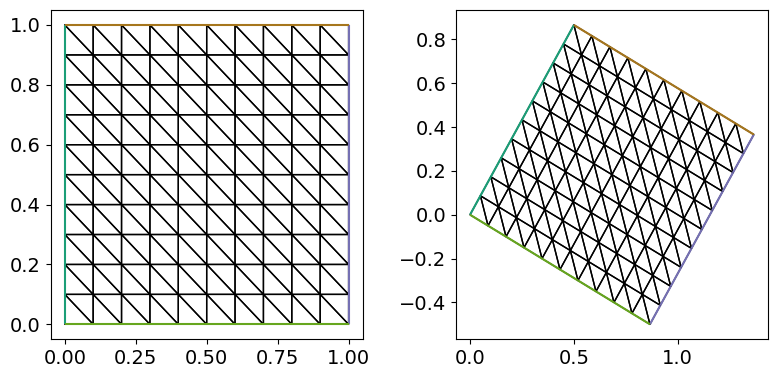

In [ ]:
import numpy as np

# test_mesh = UnitDiskMesh(refinement_level=3)
test_mesh = RectangleMesh(10, 10, 1, 1)

fig, ax = plt.subplots(1, 2, figsize=[8, 4])
handle = triplot(test_mesh, axes=ax[0])

theta = np.pi/6
R = np.array([[np.cos(theta), - np.sin(theta)], 
              [np.sin(theta),   np.cos(theta)]])

# test_mesh.coordinates.dat.datas[:] = test_mesh.coordinates.dat.data_ro[:]@R
test_mesh.coordinates.dat.data_with_halos[:] = test_mesh.coordinates.dat.data_ro_with_halos[:]@R

handle = triplot(test_mesh, axes=ax[1])
fig.tight_layout()

### 简单映射边界点

等参元映射通过更改坐标向量场实现: 从线性网格开始构造, 把边界上的自由度移动到边界上. 以单位圆为例:

```python
def points2bdy(points):
    r = np.linalg.norm(points, axis=1).reshape([-1, 1])
    return points/r

def make_high_order_mesh_map_bdy(m, p):
    coords = m.coordinates
    V_p = VectorFunctionSpace(m, 'CG', p)
    coords_p = Function(V_p, name=f'coords_p{i}').interpolate(coords)
    
    bc = DirichletBC(V_p, 0, 'on_boundary')
    points = coords_p.dat.data_ro_with_halos[bc.nodes]
    coords_p.dat.data_with_halos[bc.nodes] = points2bdy(points)
    
    return Mesh(coords_p)
```

### 同时移动边界单元的内点

Reference:

1. [M. Lenior, Optimal Isoparametric Finite Elements and Error Estimates For Domains Involving Curved Boundaries. SIAM. J. Numer. Anal. 23(3). 1986. pp 562--580.](https://epubs.siam.org/doi/10.1137/0723036)


等参元映射通过更改坐标向量场实现: 从线性网格开始构造, 把边界上的自由度移动到边界上, 同时移动边界单元的内部自由度.

```python
def make_high_order_mesh_simple(m, p):
    if p == 1:
        return m

    coords_1 = m.coordinates
    coords_i = coords_1
    for i in range(2, p+1):
        coords_im1 = coords_i
        V_i = VectorFunctionSpace(m, 'CG', i)
        bc = DirichletBC(V_i, 0, 'on_boundary')
        coords_i = Function(V_i, name=f'coords_p{i}').interpolate(coords_im1)
        coords_i.dat.data_with_halos[bc.nodes] = \
            points2bdy(coords_i.dat.data_ro_with_halos[bc.nodes])

    return Mesh(coords_i)
```

__注__: 
这是一个简单的实现, 并不完全符合文献[1]中等参元映射构造方式, 一个完整的实现方式见文件 [py/make_mesh_circle_in_rect.py](py/make_mesh_circle_in_rect.py) 中的函数 `make_high_order_coords_for_circle_in_rect`: 该函数实现了内部具有一个圆形界面的矩形区域上的等参映射.

### 数值实验

精确解为 $u =  1 - (x^2 + y^2)^{3.5}$

In [ ]:
%run py/possion_convergence_circle.py -max_degree 3 -exact "1 - (x[0]**2 + x[1]**2)**3.5"

Exact solution:  1 - (x[0]**2 + x[1]**2)**3.5 

p = 1; Use iso: False; Only move bdy: False.
    Rel. H1 errors: [0.21472147 0.10953982 0.05505367]
            orders: [0.99748178 1.00490702]
    Rel. L2 errors: [0.02973733 0.00764636 0.00192565]
            orders: [2.01284532 2.01420929]

p = 2; Use iso: False; Only move bdy: False.
    Rel. H1 errors: [0.02567607 0.00823192 0.00274559]
            orders: [1.68586184 1.60384374]
    Rel. L2 errors: [0.00804638 0.00197793 0.00048968]
            orders: [2.07953304 2.0391775 ]

p = 2; Use iso: True; Only move bdy: False.
    Rel. H1 errors: [0.02049517 0.00516031 0.0012846 ]
            orders: [2.04399704 2.03112667]
    Rel. L2 errors: [1.32436157e-03 1.65779996e-04 2.05806815e-05]
            orders: [3.07968268 3.04739627]

p = 3; Use iso: False; Only move bdy: False.
    Rel. H1 errors: [0.01465085 0.00517696 0.00182789]
            orders: [1.54172011 1.52063516]
    Rel. L2 errors: [0.00786267 0.00195543 0.00048687]
          

## 间断有限元方法

### UFL 符号
+ `+`:  

    `u('-')`

+ `-`:  

    `u('+')`

+ avg:  

    `(u('+') + u('-'))/2`

+ jump: 
    
    `jump(u, n) = u('+')*n('+') + u('-')*n('-')`
    
    `jump(u) = u('+') - u('-')`

+ FacetNormal:

    边界法向

+ CellDiameter:
    
    网格尺寸

### UFL 测度
1. `ds` 外部边
2. `dS` 内部边

### 变分形式

\begin{equation}
\begin{aligned}
    \int_\Omega \nabla u \cdot \nabla v 
    &- \int_{EI} (\{\nabla u\}[vn] + [un]\{\nabla v\})
     - \frac{\alpha}{h}\int_{EI} [un][vn] \\
    &- \int_{EO} (v n \nabla u  + u n \nabla v)
     - \frac{\alpha}{h}\int_{EO} uv \\
    &- \int_\Omega f v   - \int_{\partial\Omega_N} g_N v = 0
\end{aligned}
\end{equation}
其中 $[vn] = v^+n^+ + v^-n^-, \{u\} = (u^+ + u^-)/2$

In [ ]:
mesh = RectangleMesh(8, 8, 1, 1)

DG1 = FunctionSpace(mesh, 'DG', 1)
u, v = TrialFunction(DG1), TestFunction(DG1)

x, y = SpatialCoordinate(mesh)
f = sin(pi*x)*sin(pi*y)

h = Constant(2.0)*Circumradius(mesh)
alpha = Constant(1)
gamma = Constant(1)

n = FacetNormal(mesh)

a = inner(grad(u), grad(v))*dx \
  - dot(avg(grad(u)), jump(v, n))*dS \
  - dot(jump(u, n), avg(grad(v)))*dS \
  + alpha/avg(h)*dot(jump(u, n), jump(v, n))*dS \
  - dot(grad(u), v*n)*ds \
  - dot(u*n, grad(v))*ds \
  + gamma/h*u*v*ds

L = f*v*dx

u_h = Function(DG1, name='u_h')
bc = DirichletBC(DG1, 0, 'on_boundary')
solve(a == L, u_h, bcs=bc)

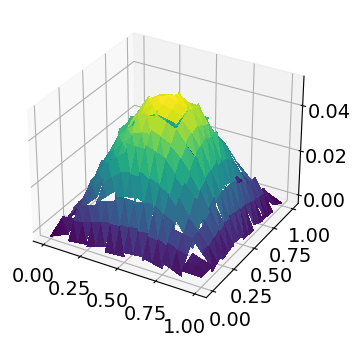

In [ ]:
fig, ax = plt.subplots(figsize=[8, 4], subplot_kw=dict(projection='3d'))
ts = trisurf(u_h, axes=ax)

### Positive and negative part of inner boundary

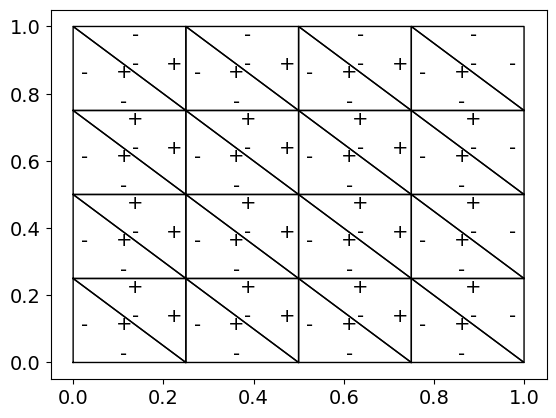

In [ ]:
from firedrake import *
from firedrake.petsc import PETSc

import os, sys
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 14})

N = PETSc.Options().getInt('N', default=4)

m = RectangleMesh(N, N, 1, 1)
V = FunctionSpace(m, 'DG', 0)
Vc = VectorFunctionSpace(m, 'DG', 0)
V_e = FunctionSpace(m, 'HDivT', 0)
V_ec = VectorFunctionSpace(m, 'HDivT', 0)

x, y = SpatialCoordinate(m)
u = Function(V, name='u')
uc = Function(Vc).interpolate(m.coordinates)
u_e = Function(V_e, name='u_e')
u_ec = Function(V_ec).interpolate(m.coordinates)

ncell = len(u.dat.data_ro)

factor = 0.7
for i in range(ncell):
    cell = V.cell_node_list[i][0]
    u.dat.data_with_halos[:] = 0
    u.dat.data_with_halos[cell] = 1
    es = V_e.cell_node_list[i]
    cc = uc.dat.data_ro_with_halos[cell, :]
    
    vertex = m.coordinates.dat.data_ro_with_halos[
        m.coordinates.function_space().cell_node_list[i]
    ]
    vertex = np.vstack([vertex, vertex[0]])
    plt.plot(vertex[:, 0], vertex[:, 1], 'k', lw=1)
    
    for e in es:
        u_e.dat.data_with_halos[:] = 0
        u_e.dat.data_with_halos[e] = 1
        ec = u_ec.dat.data_ro_with_halos[e, :]
        dis = ec - cc
        
        v_p, v_m = assemble(u('+')*u_e('+')*dS), assemble(u('-')*u_e('-')*dS)
        _x = cc[0] + factor*dis[0]
        _y = cc[1] + factor*dis[1]

        plt.text(_x, _y, '+' if v_p > 0 else '-', ha='center', va='center')
        
rank, size = m.comm.rank, m.comm.size
if not os.path.exists('figures'):
    os.makedirs('figures')
plt.savefig(f'figures/dgflag_{size}-{rank}.pdf')

## Dirac Delta 函数

### 通过数值积分公式实现 dirac delta 函数

In [ ]:
from firedrake import *

from firedrake.petsc import PETSc
from pyop2 import op2
from pyop2.datatypes import ScalarType
from mpi4py import MPI
import finat
import numpy as np

import matplotlib.pyplot as plt

set_level(CRITICAL) # Disbale warnings

class DiracOperator(object):
    def __init__(self, m, x0):
        """Make Dirac delta operator at point

        Args:
            m: mesh
            x0: source point

        Example:
            delta = DiracOperator(m, x0)
            f = Function(V)
            f_x0 = assemble(delta(f))
        """
        self.mesh = m
        self.x0 = x0
        self.operator = None
        
    def __call__(self, f):
        if self.operator is None:
            self._init()
        return self.operator(f)

    def _init(self):
        m = self.mesh
        x0 = self.x0
        V = FunctionSpace(m, 'DG', 0)
        cell_marker = Function(V, name='cell_marker', dtype=ScalarType)
        qrule = finat.quadrature.make_quadrature(V.finat_element.cell, 0)
        cell, X = m.locate_cell_and_reference_coordinate(x0, tolerance=1e-6)

        # c = 0 if X is None else 1
        n_cell_local = len(cell_marker.dat.data)
        if X is not None and cell < n_cell_local:
            c = 1
        else:
            c = 0

        comm = m.comm
        s = comm.size - comm.rank
        n = comm.allreduce(int(s*c), op=MPI.MAX)

        if n == 0:
            raise BaseException("Points not found!")

        k = int(comm.size - n) # get the lower rank which include the point x0

        if c == 1 and comm.rank == k:
            X[X<0] = 0
            X[X>1] = 1
            cell_marker.dat.data[cell] = 1
            comm.bcast(X, root=k)
        else:
            cell_marker.dat.data[:] = 0 # we must set this otherwise the process will hangup
            X = comm.bcast(None, root=k)


        cell_marker.dat.global_to_local_begin(op2.READ)
        cell_marker.dat.global_to_local_end(op2.READ)

        qrule.point_set.points[0] = X
        qrule.weights[0] = qrule.weights[0]/np.real(assemble(cell_marker*dx))

        self.operator = lambda f: f*cell_marker*dx(scheme=qrule)


### 测试 `DiracOperator`

In [ ]:
def test_dirca_delta_1D():
    test_mesh = IntervalMesh(8, 1)
    V = FunctionSpace(test_mesh, 'CG', 3)
    x1 = 0.683
    source = Constant([x1,])
    delta = DiracOperator(test_mesh, source)

    x, = SpatialCoordinate(test_mesh)
    g = Function(V).interpolate(x**2)

    expected_value =  g.at([x1])
    value = assemble(delta(g))
    PETSc.Sys.Print(f"value = {value}, expected value = {expected_value}")


test_dirca_delta_1D()

value = 0.46648900000000015, expected value = 0.4664890000000098


/home/yzz/firedrake/real-int32-mkl-debug/src/ufl/ufl/utils/sorting.py:94: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn("Applying str() to a metadata value of type {0}, don't know if this is safe.".format(type(value).__name__))


In [ ]:
def test_dirca_delta_2D():
    test_mesh = RectangleMesh(8, 8, 1, 1)
    V = FunctionSpace(test_mesh, 'CG', 3)
    x1 = 0.683
    x2 = 0.333
    source = Constant([x1,x2])
    x0 = source
    delta = DiracOperator(test_mesh, source)

    x, y = SpatialCoordinate(test_mesh)
    g = Function(V).interpolate(x**3 + y**3)

    expected_value =  g.at([x1, x2])
    value = assemble(delta(g))
    PETSc.Sys.Print(f"value = {value}, expected value = {expected_value}")


test_dirca_delta_2D()

value = 0.3555380240000009, expected value = 0.3555380240000011


/home/yzz/firedrake/real-int32-mkl-debug/src/ufl/ufl/utils/sorting.py:94: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn("Applying str() to a metadata value of type {0}, don't know if this is safe.".format(type(value).__name__))


### Dirac delta 函数的 L2 投影

/home/yzz/firedrake/real-int32-mkl-debug/src/ufl/ufl/utils/sorting.py:94: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn("Applying str() to a metadata value of type {0}, don't know if this is safe.".format(type(value).__name__))


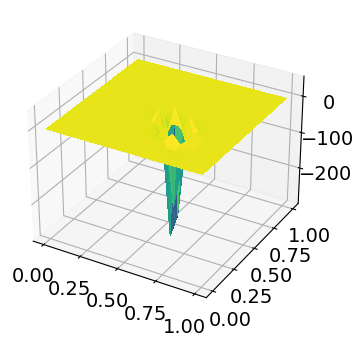

In [ ]:
test_mesh = RectangleMesh(10, 10, 1, 1)
V = FunctionSpace(test_mesh, 'CG', 3)
delta = DiracOperator(test_mesh, [0.638, 0.33])
bc = DirichletBC(V, 0, 'on_boundary')
u, v = TrialFunction(V), TestFunction(V)
sol = Function(V)
solve(u*conj(v)*dx == delta(conj(v)), sol, bcs=bc)

fig, ax = plt.subplots(figsize=[8, 4], subplot_kw=dict(projection='3d'))
ts = trisurf(sol, axes=ax) # 为什么负值那么大？

### 求解源项为 Dirca delta 函数的 Possion 方程

/home/yzz/firedrake/real-int32-mkl-debug/src/ufl/ufl/utils/sorting.py:94: UserWarning: Applying str() to a metadata value of type QuadratureRule, don't know if this is safe.
  warnings.warn("Applying str() to a metadata value of type {0}, don't know if this is safe.".format(type(value).__name__))


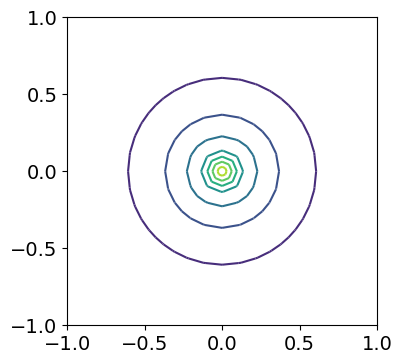

In [ ]:
x0 = [0, 0]
# N = 500
# m = SquareMesh(N, N, 1)

m = UnitDiskMesh(refinement_level=3)

V = FunctionSpace(m, 'CG', 1)

v = TestFunction(V)
u = TrialFunction(V)

a = inner(grad(u), grad(v))*dx
L = DiracOperator(m, x0)(v)
u = Function(V, name='u')

bc = DirichletBC(V, 0, 'on_boundary')

solve(a == L, u, bcs=bc)

# solve(a == L, u)
fig, ax = plt.subplots(figsize=[4, 4])
ts = tricontour(u, axes=ax)

## 自由度映射关系

### Cell node map

+ `V.dim()`: Number of dofs
+ `V.cell_node_list`: an array of cell node map (same with `V.cell_node_map().values`)

In [ ]:
mesh = RectangleMesh(8, 8, 1, 1)
V = FunctionSpace(mesh, 'CG', 1)

# the global numers of the dofs in the first 2 elements
for i in range(2): 
    print(f"cell {i}: ", V.cell_node_list[i]) 

cell 0:  [0 1 2]
cell 1:  [1 2 3]


__Example: 第一个三角形的坐标__

In [ ]:
coords = mesh.coordinates
V_c = coords.function_space()
dof_numbers = V_c.cell_node_list[0]

for i in dof_numbers:
    print(f"vertex {i}:", coords.dat.data_ro_with_halos[i])

vertex 0: [0. 0.]
vertex 1: [0.    0.125]
vertex 2: [0.125 0.   ]


### Finite element (dofs on reference cell)

In [ ]:
V = FunctionSpace(mesh, 'CG', 2)
element = V.finat_element

print("cell: ",  element.cell)
print("degree: ", element.degree)

cell:  <FIAT.reference_element.UFCTriangle object at 0x7f9f705c8490>
degree:  2


In [ ]:
element.entity_dofs() # dofs for every entity (vertex, edge, face, volume)

{0: {0: [0], 1: [1], 2: [2]}, 1: {0: [3], 1: [4], 2: [5]}, 2: {0: []}}

## Adaptive Finite Element Methods

### Possion on Lshape

File: [](py/adapt_possion.py)


1. 方程求解

   :::{literalinclude} py/adapt_possion.py
   :pyobject: solve_possion
   :::
   
2. 误差估计
   :::{literalinclude} py/adapt_possion.py
   :pyobject: estimate
   :::
   
   :::{literalinclude} py/adapt_possion.py
   :pyobject: assemble_eta_K_py
   :::
   
3. 网格标记

   :::{literalinclude} py/adapt_possion.py
   :pyobject: mark_cells
   :::

使用以上函数以及 `DMPlex` 的 `adaptLabel` 方法, 我们可以写出 L 区域上的网格自适应方法

:::{literalinclude} py/adapt_possion.py
:pyobject: adapt_possion_Lshape
:::


L 型区域上的网格自适应算例

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


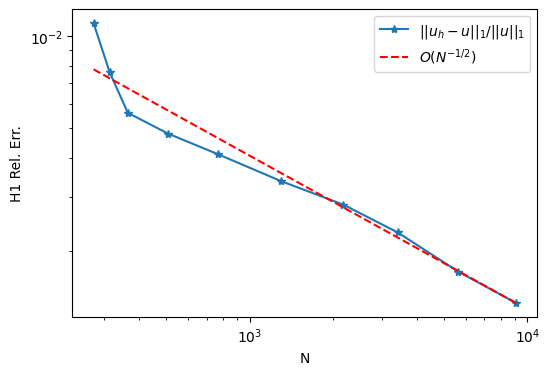

In [1]:
from py.adapt_possion import adapt_possion_Lshape, plot_adapt_result

result = adapt_possion_Lshape()
fig = plot_adapt_result(result)

### Update coordinates of DMPlex

File: [](py/update_plex_coordinates.py)

如果移动了网格, DMPlex 中存储的坐标和 Firedrake 的坐标将会不一致, 这时候做自适应加密需要把同步 Firedrake 中的坐标 DMPlex 中.

1. 根据自由度的映射关系, 更新 `plex` 的坐标.

   :::{literalinclude} py/update_plex_coordinates.py
   :pyobject: get_plex_with_update_coordinates
   :::

2. 通过设置 `Section` 的方式更新 `plex`. 

   若使用的 Firedrake 包含 [pr-29330](https://github.com/firedrakeproject/firedrake/pull/29330), 则可以使用该方式.

   :::{literalinclude} py/update_plex_coordinates.py
   :pyobject: get_plex_with_update_coordinates_new
   :::

   :::{warning}
   对于不包含 [pr-29330](https://github.com/firedrakeproject/firedrake/pull/29330) 的版本, 上述方法虽然可以更新坐标, 但是更新后的 `plex` 不可以作为 `Mesh` 的参数创建网格.
   :::


使用移动网格进行测试

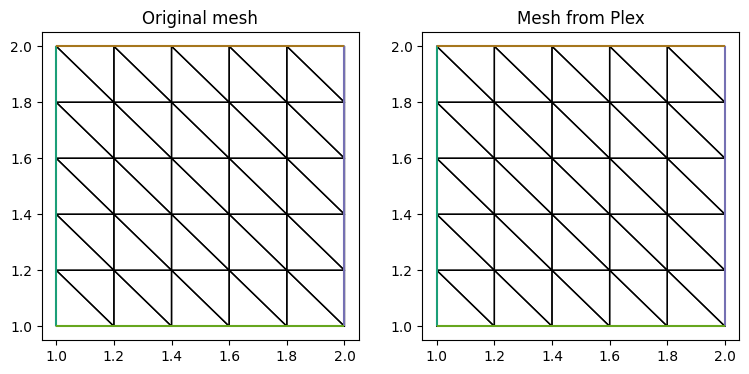

In [6]:
from firedrake import *
from py.update_plex_coordinates import \
    get_plex_with_update_coordinates, \
    get_plex_with_update_coordinates_new
import matplotlib.pyplot as plt

def save_mesh(mesh, name):
    V = FunctionSpace(mesh, 'CG', 1)
    f = Function(V, name='f')
    File(name).write(f)

mesh_init = RectangleMesh(5, 5, 1, 1)

# move mesh
mesh_init.coordinates.dat.data[:] += 1
save_mesh(mesh_init, 'pvd/mesh_init.pvd')

# recreate mesh from the plex
plex = get_plex_with_update_coordinates(mesh_init)
mesh = Mesh(plex, distribution_parameters={"partition": False})
save_mesh(mesh, 'pvd/mesh_with_update_plex.pvd')

fig, ax = plt.subplots(1, 2, figsize=[9, 4], subplot_kw={})
tp0 = triplot(mesh_init, axes=ax[0])
tp1 = triplot(mesh, axes=ax[1])
t0 = ax[0].set_title('Original mesh')
t1 = ax[1].set_title('Mesh from Plex')

### Using adaptMetric of dmplex

File [py/test_adapt_metric.py](py/test_adapt_metric.py)



除了上述 `adaptLabel` 方法, PETSc 还提供的 `adaptMetric` 方法根据用户
提供的度量矩阵对网格进行自适应.

首先使用 `create_metric_from_indicator` 把 `indicator` 转化为度量矩阵 `v`, 然后使用 `to_petsc_local_numbering` 把自由度排序更改为 PETSc 内部序. 注意这里网格每个节点对应一个度量矩阵, 用向量表示.
最后调用 `adaptMetric` 进行自适应网格剖分.

:::{literalinclude} py/test_adapt_metric.py
:pyobject: adapt
:::


方法 `create_metric_from_indicator` 根据输入参数构造度量矩阵, 其思路为先计算各单元的度量矩阵, 然后顶点的度量矩阵通过相邻单元的度量矩阵进行加权平均得到

1. 对单元循环, 求解单元度量矩阵

   :::{literalinclude} py/test_adapt_metric.py
   :linenos:
   :lineno-match:
   :lines: 80-92
   :::

   这里用到了 `edge2vec` 用于根据单元边向量构造计算度量矩阵的矩阵

   :::{literalinclude} py/test_adapt_metric.py
   :linenos:
   :lineno-match:
   :lines: 66-73
   :::

2. 根据单元体积进行加权平均, 计算顶点的度量矩阵

   :::{literalinclude} py/test_adapt_metric.py
   :linenos:
   :lineno-match:
   :lines: 94-96
   :::


方法 `to_petsc_local_numbering` 内容如下

:::{literalinclude} py/test_adapt_metric.py
:pyobject: to_petsc_local_numbering
:::

通过命令行选项或 `OptionsManager`, 我们可以控制使用的自适应库 `pragmatic`, `mmg`, `parmmg`.

:::{literalinclude} py/test_adapt_metric.py
:pyobject: test_adapt
:::

:::{literalinclude} py/test_adapt_metric.py
:pyobject: test_adapt_with_option
:::

下面我们展示一个三维立方体区域自适应的结果

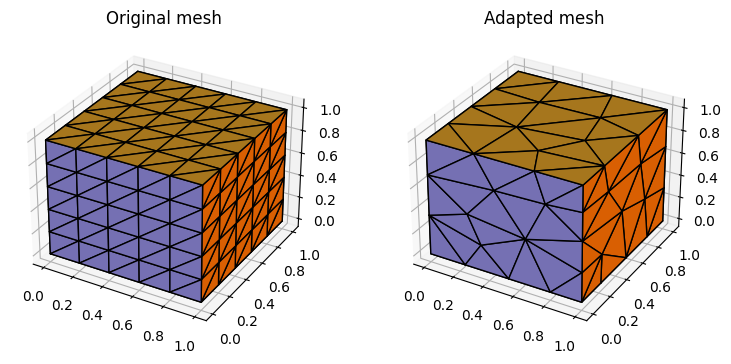

In [3]:
from py.test_adapt_metric import test_adapt, test_adapt_with_option
from firedrake import triplot
import matplotlib.pyplot as plt

mesh, mesh_new = test_adapt_with_option(dim=3, factor=0.3)

if mesh.geometric_dimension() == 3:
    subplot_kw = dict(projection='3d')
else:
    subplot_kw = {}
fig, ax = plt.subplots(1, 2, figsize=[9, 4], subplot_kw=subplot_kw)
tp = triplot(mesh, axes=ax[0])
tp_new = triplot(mesh_new, axes=ax[1])
t0 = ax[0].set_title('Original mesh')
t1 = ax[1].set_title('Adapted mesh')